In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse
import scanpy.external as sce
import sklearn.manifold
import statsmodels.api as sm

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyclustering.cluster.kmedoids import kmedoids

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import seaborn as sb

import scanpy as sc
import harmonypy as hm
import anndata
import pickle
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import chi2_contingency
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
import os
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

In [2]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm
from random import sample

### Load Data

In [3]:
SC_DF = sc.read_h5ad('h5ad')

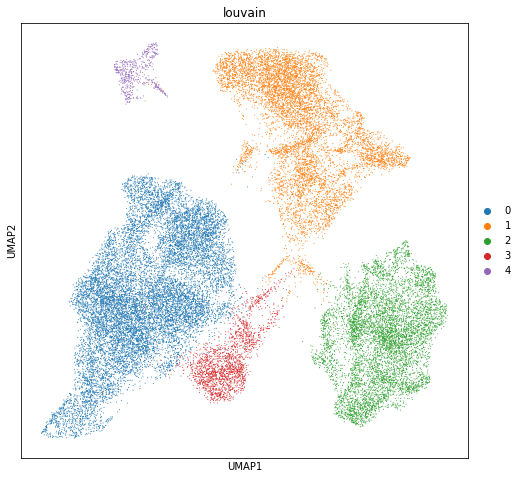

In [4]:
sc.pl.umap(SC_DF, color = 'louvain', use_raw=True)

### Subset Cardiac and adjacent clusters. Recluster using UMAP

In [5]:
sg_pos = []

for cell in SC_DF.obs.index:
    if SC_DF.obs.loc[cell].louvain == '1':
        sg_pos.append(cell)

cardiac_cells = SC_DF[sg_pos]

In [6]:
sc.tl.pca(cardiac_cells, random_state= 0)

computing PCA
    with n_comps=50
    finished (0:00:14)


In [7]:
sce.tl.phate(cardiac_cells, k= 10, a= 100, random_state = 0)

computing PHATE


Calculating PHATE...
  Running PHATE on 7989 cells and 29230 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.47 seconds.
    Calculating affinities...
    Calculated affinities in 0.21 seconds.
  Calculated graph and diffusion operator in 16.95 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 38.20 seconds.
  Calculated landmark operator in 40.81 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.81 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.48 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 22.06 seconds.
Calculated PHATE in 82.12 seconds.


    finished: added
    'X_phate', PHATE coordinates (adata.obsm) (0:01:22)


In [8]:
sc.pp.neighbors(
    cardiac_cells,
    use_rep='X_pca',
    random_state = 0
)
#standard is no neighbors
#sc.tl.diffmap(adata_filtered)
#sc.pp.neighbors(adata_filtered, n_neighbors=10, use_rep='X_diffmap')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [9]:
### Cluster the neighborhood graph
#sc.tl.leiden(adata_filtered)
sc.tl.louvain(
    cardiac_cells,
    resolution = .6,
    random_state = 0)
#For good clustering use 0.025
#Standard use 0.4
#sc.tl.phate(adata_filtered, k=3, a=20, n_jobs=-2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


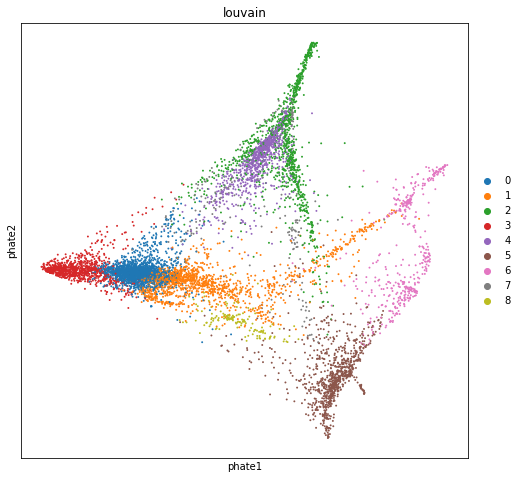

In [10]:
sce.pl.phate(cardiac_cells, color = 'louvain')

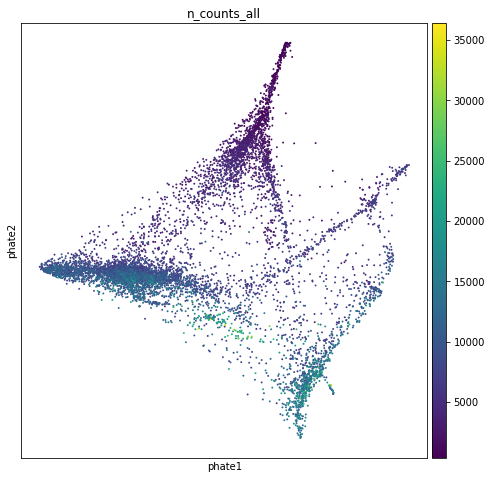

In [17]:
sce.pl.phate(cardiac_cells, color = 'n_counts_all')

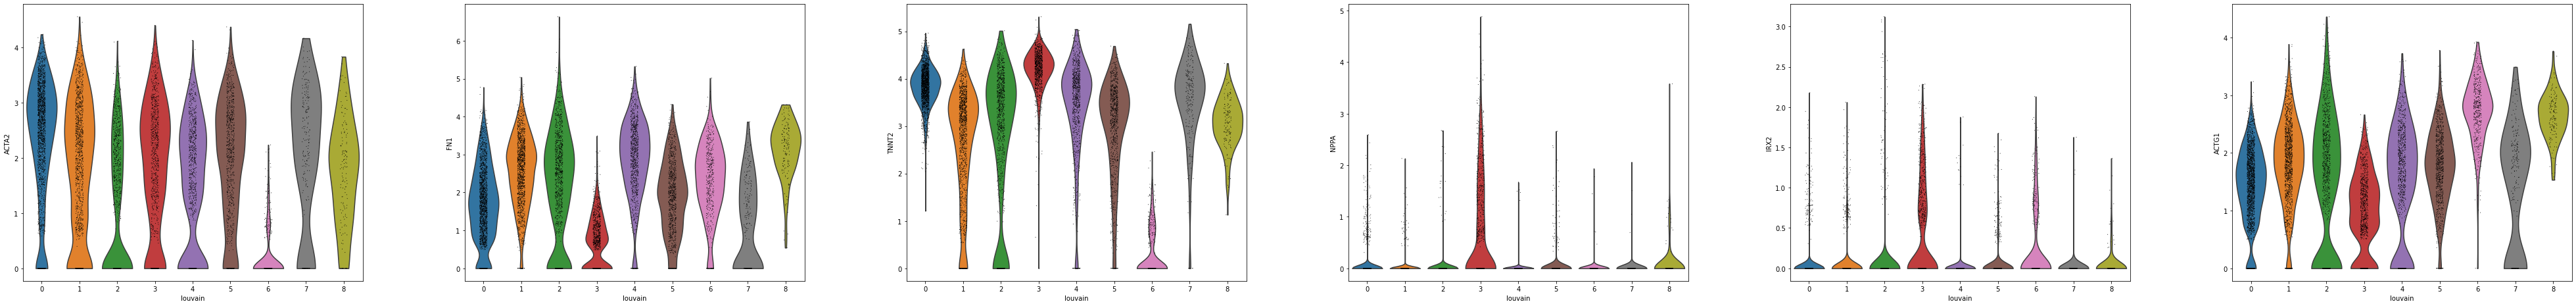

In [13]:
Gene_List = ['ACTA2', 'FN1', 'TNNT2', 'NPPA', 'IRX2', 'ACTG1']
sc.pl.violin(cardiac_cells, groupby='louvain', keys = Gene_List)
Interested_Cluster = ['0', '3', '1','6']

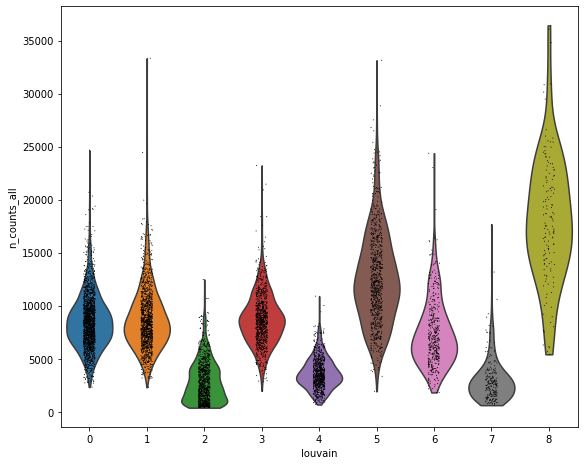

In [18]:
sc.pl.violin(cardiac_cells, groupby='louvain', keys = 'n_counts_all')

In [201]:
sc.tl.rank_genes_groups(cardiac_cells, groupby='louvain', key_added='rank_genes_r1.0')

ranking genes
    finished: added to `.uns['rank_genes_r1.0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


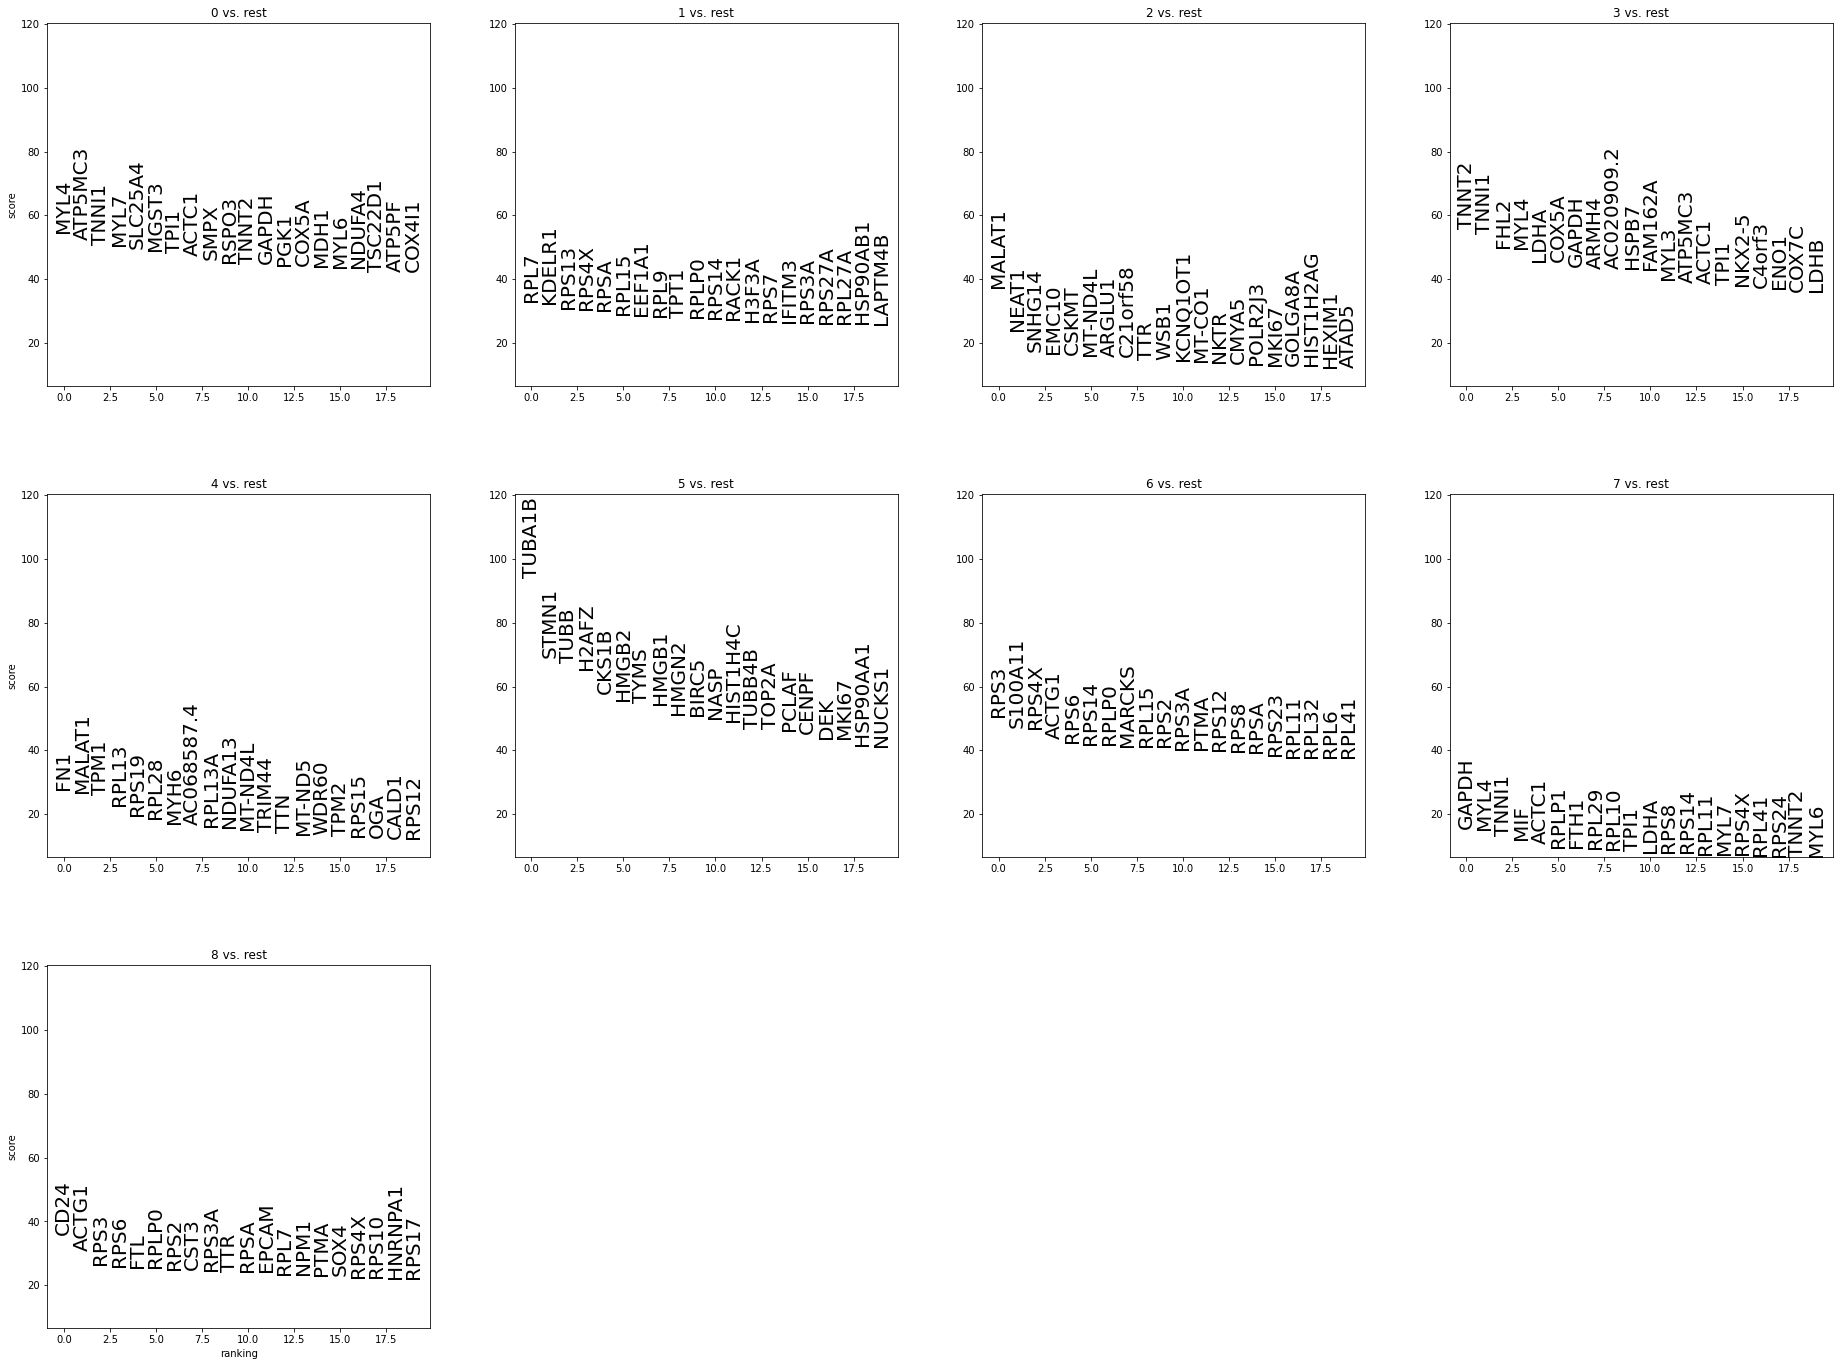

In [202]:
sc.pl.rank_genes_groups(cardiac_cells, key='rank_genes_r1.0',fontsize=20)

In [19]:
cardiac_cells.uns['iroot'] = np.flatnonzero(cardiac_cells.obs['louvain']  == '3')[0]

In [20]:
sc.tl.dpt(cardiac_cells)


computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9852681  0.9783896  0.975051   0.9649039  0.9599329
     0.955173   0.95099205 0.94833004 0.94327    0.94086874 0.9319397
     0.9281304  0.9250357  0.9186196 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


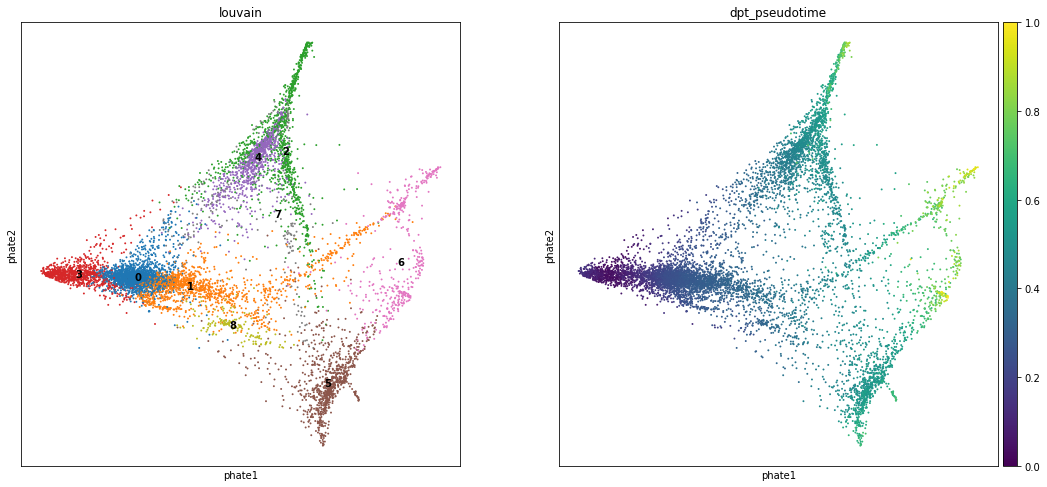

In [21]:
sce.pl.phate(cardiac_cells, color=['louvain', 'dpt_pseudotime'], legend_loc='on data')


In [24]:
# Calculate ranks of pseudotime
array = np.array(cardiac_cells.obs['dpt_pseudotime'])

temp = array.argsort()

ranks = np.empty_like(temp)

ranks[temp] = np.arange(len(array))

cardiac_cells.obs['rank_pseudotime'] = ranks

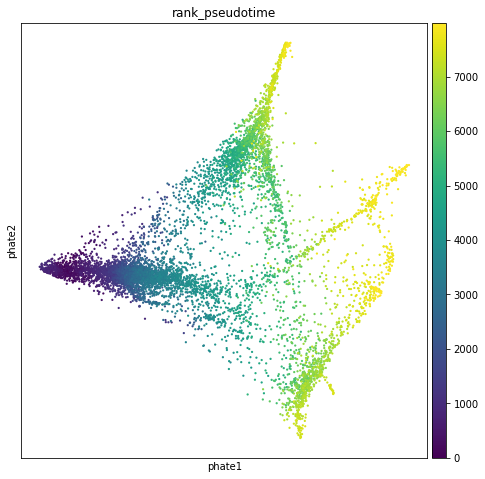

In [25]:
# Figure 4B
sce.pl.phate(cardiac_cells, color='rank_pseudotime', size=20, 
#          save='_BL41Only_rank_pseudotime.pdf'
          )

### Subset Cells and Rerun PHATE (Selected for cardiac cells)

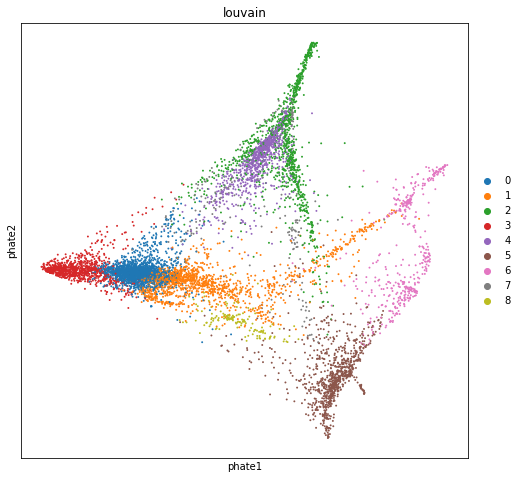

In [22]:
sce.pl.phate(cardiac_cells, color = 'louvain')

In [235]:
sg_pos = []
Interested_Cluster = ['0', '3', '1','6']
for cell in cardiac_cells.obs.index:
    if cardiac_cells[cell].obs.louvain.tolist()[0] in Interested_Cluster:
        sg_pos.append(cell)
cardiac_cells_subset = cardiac_cells[sg_pos]

In [236]:
sc.tl.pca(cardiac_cells_subset, random_state= 0)

computing PCA
    with n_comps=50
    finished (0:00:13)


In [237]:
#sce.tl.phate(cardiac_cells, k= 50, a= 100, random_state = 0)
#sce.tl.phate(cardiac_cells, k= 60, a= 100, random_state = 0)
#sce.tl.phate(cardiac_cells, k= 60, a= 100, random_state = 0)
#sce.tl.phate(cardiac_cells, k= 200, a= 100, random_state = 0)
sce.tl.phate(cardiac_cells_subset, k=10, a= 100, random_state = 0)

computing PHATE


Calculating PHATE...
  Running PHATE on 4717 cells and 29230 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.85 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.84 seconds.
    Calculating affinities...
    Calculated affinities in 0.17 seconds.
  Calculated graph and diffusion operator in 12.89 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.15 seconds.
    Calculating KMeans...
    Calculated KMeans in 52.84 seconds.
  Calculated landmark operator in 55.79 seconds.
  Calculating optimal t...
  Calculated optimal t in 2.38 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.76 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 24.65 seconds.
Calculated PHATE in 96.49 seconds.


    finished: added
    'X_phate', PHATE coordinates (adata.obsm) (0:01:36)


In [238]:
sc.pp.neighbors(
    cardiac_cells_subset,
    use_rep='X_pca',
    random_state = 0
)
#standard is no neighbors
#sc.tl.diffmap(adata_filtered)
#sc.pp.neighbors(adata_filtered, n_neighbors=10, use_rep='X_diffmap')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [239]:
### Cluster the neighborhood graph
#sc.tl.leiden(adata_filtered)
sc.tl.louvain(
    cardiac_cells_subset,
    resolution = .3)
#For good clustering use 0.025
#Standard use 0.4
#sc.tl.phate(adata_filtered, k=3, a=20, n_jobs=-2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


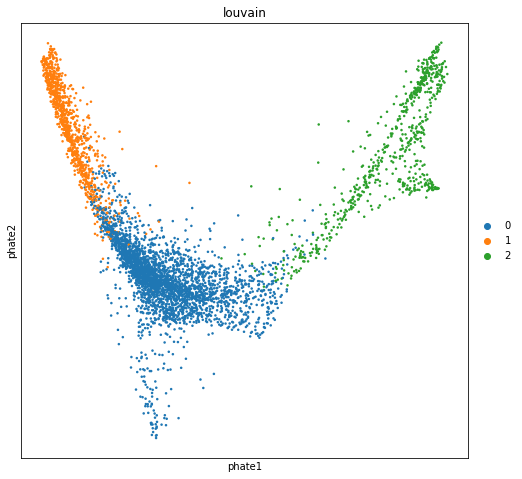

In [240]:
sce.pl.phate(cardiac_cells_subset, color = 'louvain')

In [241]:
cardiac_cells_subset.uns['iroot'] = np.flatnonzero(cardiac_cells_subset.obs['louvain']  == '2')[0]

In [242]:
sc.tl.dpt(cardiac_cells_subset)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [243]:
# Calculate ranks of pseudotime
array = np.array(cardiac_cells_subset.obs['dpt_pseudotime'])

temp = array.argsort()

ranks = np.empty_like(temp)

ranks[temp] = np.arange(len(array))

cardiac_cells_subset.obs['rank_pseudotime'] = ranks

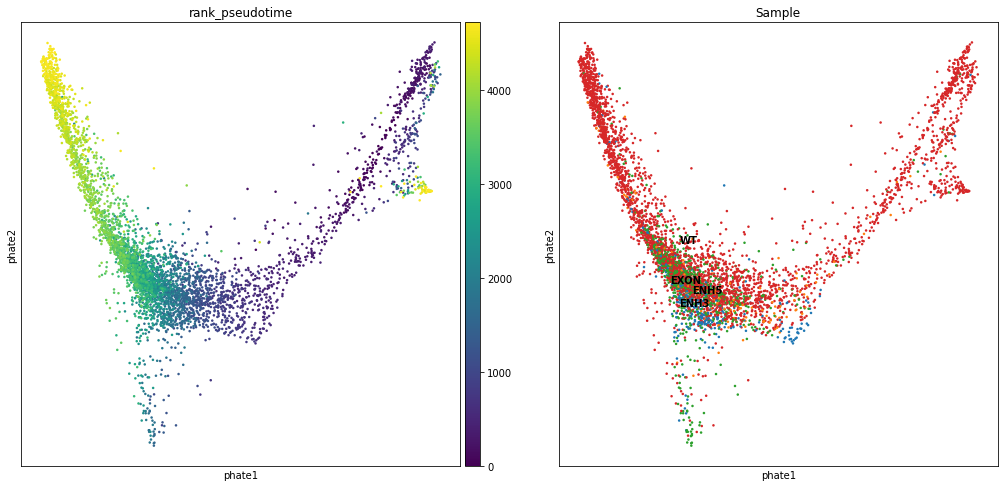

In [244]:
sce.pl.phate(cardiac_cells_subset, color=['rank_pseudotime', 'Sample'], legend_loc='on data')

In [245]:
sc.tl.rank_genes_groups(cardiac_cells_subset, groupby='louvain', key_added='broad_clusters', method = 'wilcoxon')

ranking genes
    finished: added to `.uns['broad_clusters']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


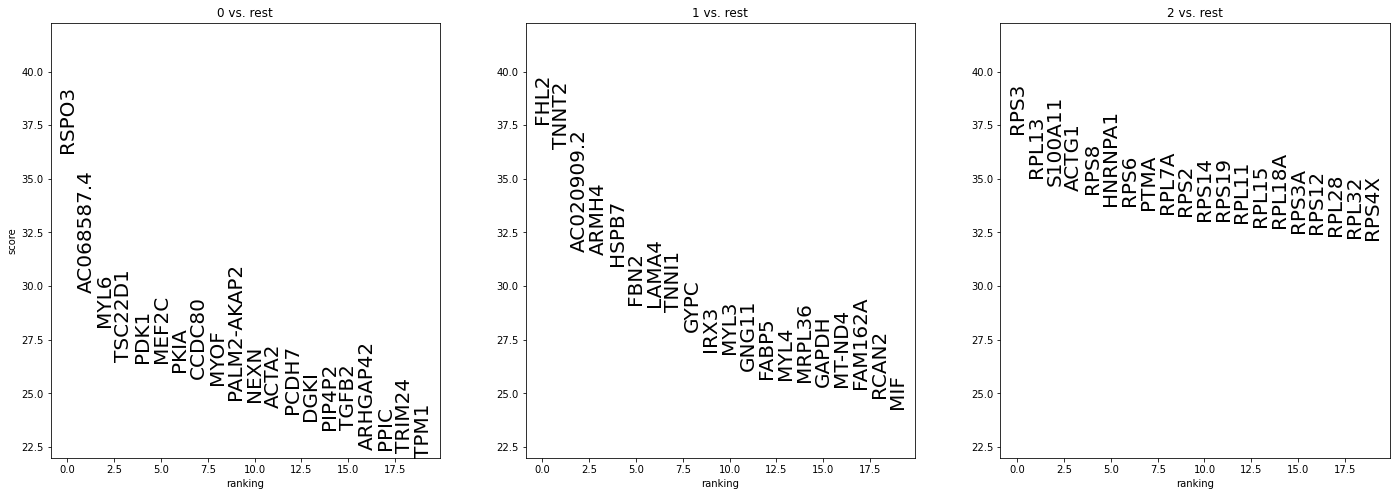

In [246]:
sc.pl.rank_genes_groups(cardiac_cells_subset, key='broad_clusters',fontsize=20)

In [247]:
Sample_List = ['WT:B1','PROM:B1','ENH3:B1', 'ENH5:B1', 'WT:B2','PROM:B2','ENH3:B2', 'ENH5:B2']
Sample_Col = [0,1,2,3,0,1,2,3]

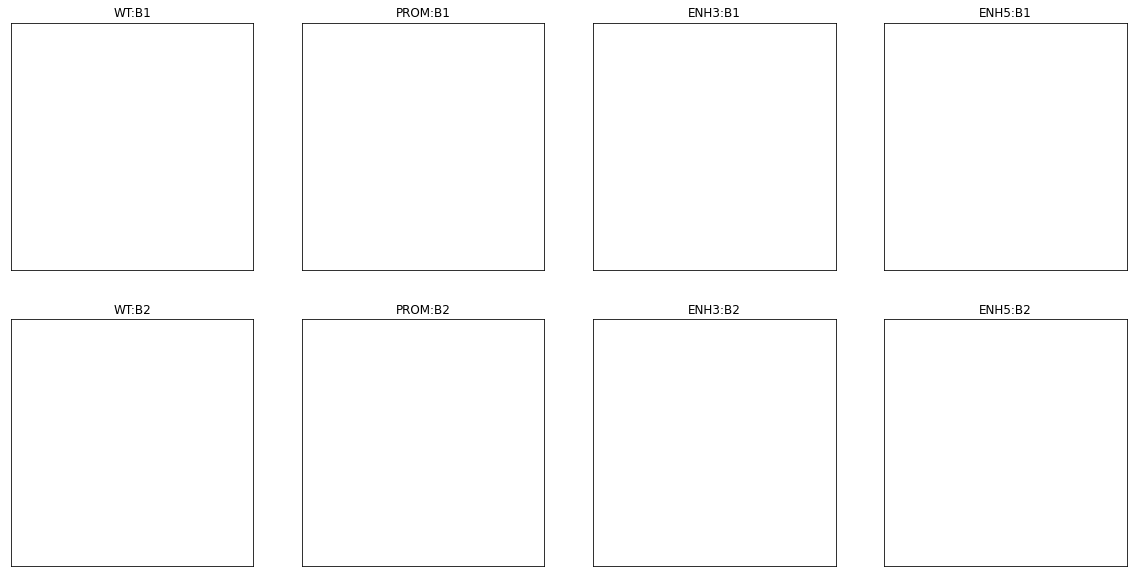

In [249]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True)

for i,sample in enumerate(Sample_List):
    sg_pos_cell = []
    for bc in cardiac_cells_subset.obs.index:
        if bc in cardiac_cells_subset[cardiac_cells_subset.obs['B_Reps'] == sample].obs.index:
            sg_pos_cell.append(1)
        else:
            sg_pos_cell.append(0)
    
    
    
    if sample.split(':')[1] == 'B1':
        row_set = 0
    else:
        row_set = 1
    col_set = Sample_Col[i]
        
    ax=axes[row_set,col_set]
    
    indices = np.nonzero(sg_pos_cell)[0]
    x = cardiac_cells_subset.obsm['X_phate'][indices,0]
    y = cardiac_cells_subset.obsm['X_phate'][indices,1]
    ax.scatter(x, 
               y, 
               c='#c44e52',
               s=1,
            alpha=0.8)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(sample)
    ax.grid(False)

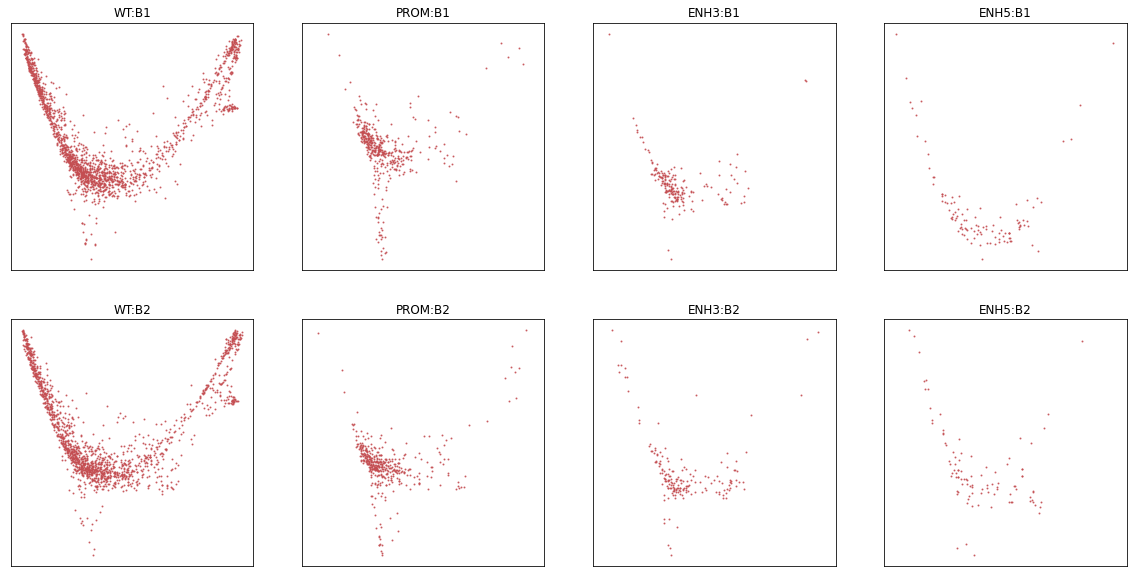

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True)

for i,sample in enumerate(Sample_List):
    sg_pos_cell = []
    for bc in cardiac_cells_subset.obs.index:
        if bc in cardiac_cells_subset[cardiac_cells_subset.obs['B_Reps'] == sample].obs.index:
            sg_pos_cell.append(1)
        else:
            sg_pos_cell.append(0)
    
    
    
    if sample.split(':')[1] == 'B1':
        row_set = 0
    else:
        row_set = 1
    col_set = Sample_Col[i]
        
    ax=axes[row_set,col_set]
    
    indices = np.nonzero(sg_pos_cell)[0]
    x = cardiac_cells_subset.obsm['X_phate'][indices,0]
    y = cardiac_cells_subset.obsm['X_phate'][indices,1]
    ax.scatter(x, 
               y, 
               c='#c44e52',
               s=1,
            alpha=0.8)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(sample)
    ax.grid(False)

In [248]:
cardiac_cells_subset.write('h5ad')